In [11]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from collections import Counter

In [12]:
# Data Loading and Preprocessing Functions
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def normalize_signals(X):
    mean = np.mean(X, axis=1, keepdims=True)
    std = np.std(X, axis=1, keepdims=True)
    X_norm = (X - mean) / (std + 1e-8)
    return X_norm

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

def compute_class_weights(y_train):
    """
    Compute class weights based on training label distribution.
    """
    class_counts = Counter(y_train)
    total_samples = sum(class_counts.values())
    class_weights = {label: total_samples / count for label, count in class_counts.items()}
    weights = [class_weights[label] for label in y_train]
    return weights

def split_data(X, Y):
    test_fold = 10
    X_train = X[Y.strat_fold != test_fold]
    y_train = Y[Y.strat_fold != test_fold]['label'].values
    X_test = X[Y.strat_fold == test_fold]
    y_test = Y[Y.strat_fold == test_fold]['label'].values
    return X_train, y_train, X_test, y_test

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size=32):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Shape: (batch_size, seq_len, channels)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def create_dataloaders_with_sampler(X_train, y_train, X_test, y_test, batch_size=32):
    """
    Create DataLoaders with WeightedRandomSampler for balanced sampling.
    """
    # Compute weights for the training set
    train_weights = compute_class_weights(y_train)
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=train_weights, 
        num_samples=len(train_weights), 
        replacement=True
    )
    
    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


In [13]:
# Load Data
path = '../dataset/'
sampling_rate = 100

Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
X = load_raw_data(Y, sampling_rate, path)

agg_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Filter and Encode Labels
has_superclass = Y['diagnostic_superclass'].apply(lambda x: len(x) > 0)
X = X[has_superclass.values]
Y = Y[has_superclass]

# Assign a single superclass label (choose the first one)
Y['superclass_label'] = Y['diagnostic_superclass'].apply(lambda x: x[0])

# Map superclasses to integer labels
superclasses = sorted(Y['superclass_label'].unique())
superclass_to_int = {k: v for v, k in enumerate(superclasses)}
int_to_superclass = {v: k for k, v in superclass_to_int.items()}
Y['label'] = Y['superclass_label'].map(superclass_to_int)
num_classes = len(superclasses)

print("Diagnostic superclasses and their corresponding labels:")
for k, v in superclass_to_int.items():
    print(f"{k}: {v}")

Diagnostic superclasses and their corresponding labels:
CD: 0
HYP: 1
MI: 2
NORM: 3
STTC: 4


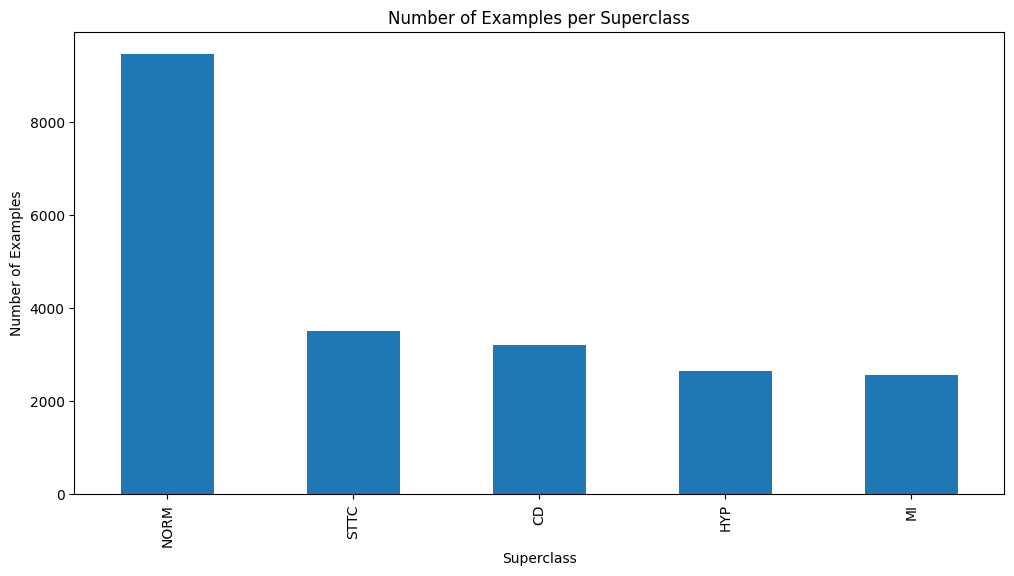

In [14]:
plt.figure(figsize=(12, 6))
Y['superclass_label'].value_counts().plot(kind='bar')
#Y['label'].value_counts()
plt.title('Number of Examples per Superclass')
plt.xlabel('Superclass')
plt.ylabel('Number of Examples')
plt.show()

In [15]:
# Model Definition
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        # Define the output layer
        direction = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * direction, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_len, hidden_size * num_directions)

        # Take the output from the last time step
        out = out[:, -1, :]  # (batch_size, hidden_size * num_directions)

        # Pass through the fully connected layer
        out = self.fc(out)  # (batch_size, num_classes)
        return out

In [25]:
# Training Function
from sklearn.metrics import accuracy_score, f1_score
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=20):
    f1=[]
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            # Move data to the appropriate device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        
        # Evaluation
        model.eval()
        y_pred = []
        y_true = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(y_batch.numpy())
        acc = accuracy_score(y_true, y_pred)
        f1.append(f1_score(y_true, y_pred, average='macro'))
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {acc*100:.2f}%")
    print("Training complete.")
    print(f"Average F1 Score: {np.mean(f1):.4f}")

In [26]:
class CNNClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128, num_classes)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.transpose(1, 2)  # Change shape to (batch_size, input_size, seq_len)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.mean(dim=2)  # Global average pooling
        x = self.fc(x)
        return x

In [ ]:
# Split Data
X_train, y_train, X_test, y_test = split_data(X, Y)

# Normalize Data
X_train = normalize_signals(X_train)
X_test = normalize_signals(X_test)

# Create Data Loaders
train_loader, test_loader = create_dataloaders_with_sampler(X_train, y_train, X_test, y_test, batch_size=32)



# Training Parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Model parameters
input_size = X_train.shape[2]  # Number of features (channels)
hidden_size = 128
num_layers = 2
num_classes = len(superclasses)
bidirectional = True  # Set to True for a bidirectional LSTM

# Initialize the model, loss function, and optimizer
#model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes, bidirectional).to(device)
model = CNNClassifier(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Train the Model
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=20)

Using device: mps
Epoch [1/30], Loss: 1.2339, Accuracy: 61.45%
Epoch [2/30], Loss: 1.0760, Accuracy: 58.48%
Epoch [3/30], Loss: 1.0446, Accuracy: 65.11%
Epoch [4/30], Loss: 1.0233, Accuracy: 61.82%
Epoch [5/30], Loss: 1.0066, Accuracy: 64.97%
Epoch [6/30], Loss: 0.9889, Accuracy: 65.11%
Epoch [7/30], Loss: 0.9641, Accuracy: 64.60%
Epoch [8/30], Loss: 0.9634, Accuracy: 65.38%
Epoch [9/30], Loss: 0.9519, Accuracy: 64.41%
Epoch [10/30], Loss: 0.9484, Accuracy: 63.02%
Epoch [11/30], Loss: 0.9422, Accuracy: 64.18%
Epoch [12/30], Loss: 0.9276, Accuracy: 63.99%
Epoch [13/30], Loss: 0.9314, Accuracy: 62.00%
Epoch [14/30], Loss: 0.9201, Accuracy: 66.54%
Epoch [15/30], Loss: 0.9041, Accuracy: 64.37%
Epoch [16/30], Loss: 0.8947, Accuracy: 67.98%
Epoch [17/30], Loss: 0.8946, Accuracy: 65.52%
Epoch [18/30], Loss: 0.8937, Accuracy: 65.43%
Epoch [19/30], Loss: 0.8840, Accuracy: 66.27%
Epoch [20/30], Loss: 0.8524, Accuracy: 62.28%
Epoch [21/30], Loss: 0.8577, Accuracy: 62.28%
Epoch [22/30], Loss: 0.84